In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [59]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [135]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [137]:
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# EDA

## Dealing with null values

In [138]:
nulls = df.isnull().sum(axis=0)
nulls[nulls != 0]

lotfrontage      259
alley           1369
masvnrtype         8
masvnrarea         8
bsmtqual          37
bsmtcond          37
bsmtexposure      38
bsmtfintype1      37
bsmtfintype2      38
electrical         1
fireplacequ      690
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
garagecond        81
poolqc          1453
fence           1179
miscfeature     1406
dtype: int64

Is it null because there is none, like in alley? Need to explore each null

### Lot Frontage

Lot frontage is the linear feet of the street.  It should not be missing.  So for filling in missing values I will usee KNNImputer after dealing with other missing values.

### Alley

In [139]:
df.alley.unique()

array([None, 'Grvl', 'Pave'], dtype=object)

From the codebook, NA means no alley access.  So instead will fill NAs with 'None'.

In [140]:
df.alley.fillna('None', inplace=True)

### Masvnr type and area

In [141]:
df[(df['masvnrtype'].isnull())|(df['masvnrarea'].isnull())][['masvnrtype','masvnrarea']]

,masvnrtype,masvnrarea
235,None,NaN
529,None,NaN
650,None,NaN
936,None,NaN
973,None,NaN
977,None,NaN
1244,None,NaN
1278,None,NaN


Those with masvnrtype is None also have msvnrarea as NaN.  As the codebook says None means none.  I'll fill the nulls with 'None' for masvnrtype and NaNs with 0. 

In [142]:
df['masvnrtype'].fillna('None',inplace=True)
df['masvnrarea'].fillna(0, inplace=True)

### Working with basement quality, condition, exposure, and finish

In [143]:
basement_variables = ['bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2']
df[df.bsmtqual.isnull()][basement_variables]

,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2
17,None,None,None,None,None
39,None,None,None,None,None
90,None,None,None,None,None
100,None,None,None,None,None
103,None,None,None,None,None
157,None,None,None,None,None
183,None,None,None,None,None
260,None,None,None,None,None
343,None,None,None,None,None
363,None,None,None,None,None


As those codebook says those with none have no basement, None will be replaced with 'None'

In [144]:
for var in basement_variables:
    df[var].fillna('None',inplace=True)

### Electrical

There is one variable with electrical value missing.  I will look at electricals with similar saleprice.

In [147]:
df[df.electrical.isnull()]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
1379,1380,80,RL,73.0,9735,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2008,WD,Normal,167500


In [148]:
df[(df.saleprice>=100000)&(df.saleprice<200000)]['electrical'].value_counts()

SBrkr    827
FuseA     66
FuseF     16
FuseP      1
Name: electrical, dtype: int64

Since SBrkr is the most common, I will fill in the missing value with SBrkr.

In [149]:
df.loc[1379,'electrical']='SBrkr'

### Fireplace quality

According to the codebook, None in fireplace quality means there is no fireplace.  Therefore None will be replace with 'None'.

In [150]:
df.fireplacequ.fillna('None',inplace=True)

### Working with garage variables

In [151]:
garage_cat_vars = ['garagetype','garagefinish','garagequal','garagecond']


According to the codebook, none values in the garage categorical variables mean no garage.  Hence None will be replaced with 'None'

In [152]:
# need to ask why this doesn't work
# df[garage_cat_vars].fillna('None',inplace=True)

df[garage_cat_vars] = df[garage_cat_vars].fillna('None')

For houses witout a garage, the garage year built doesn't make sense.  However to deal with the missing values, I'm going to replace the NaNs by 2022. 

In [153]:
df.garageyrblt.fillna(2022,inplace=True)

### Poolqc, fence, miscellaneous features

According to the codebook None values mean no pool, no fence, or no missing features.  Hence will be replaced with 'None'

In [154]:
df.poolqc.fillna('None',inplace=True)

In [155]:
df.fence.fillna('None',inplace=True)

In [156]:
df.miscfeature.fillna('None',inplace=True)

### Using KNN to handle the remaining missing values

In [157]:
nulls = df.isnull().sum(axis=0)
nulls[nulls != 0]

lotfrontage    259
dtype: int64

In [ ]:
# before doing this change ms zoning to categorical
# maybe just switch values to string

In [158]:
df2 = pd.get_dummies(df, drop_first=True)

In [159]:
imputer = KNNImputer()
df3 = pd.DataFrame(imputer.fit_transform(df2),columns=df2.columns)

In [169]:
df.lotfrontage = df3.lotfrontage.copy()
df2.lotfrontage=df3.lotfrontage.copy()

In [170]:
df3.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [171]:
df.isnull().sum()

id               0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
                ..
mosold           0
yrsold           0
saletype         0
salecondition    0
saleprice        0
Length: 81, dtype: int64

## Handling outliers

In [166]:
numerical_columns = df.select_dtypes(exclude='object').columns
numerical_columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

In [173]:
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

In [176]:
outliers = []

## Looking first at saleprice

(array([ 16.,  74., 184., 345., 252., 199., 125.,  85.,  61.,  38.,  27.,
         15.,  14.,   8.,   6.,   2.,   1.,   1.,   2.,   1.,   2.,   0.,
          0.,   0.,   2.]),
 array([ 34900.,  63704.,  92508., 121312., 150116., 178920., 207724.,
        236528., 265332., 294136., 322940., 351744., 380548., 409352.,
        438156., 466960., 495764., 524568., 553372., 582176., 610980.,
        639784., 668588., 697392., 726196., 755000.]),
 <BarContainer object of 25 artists>)

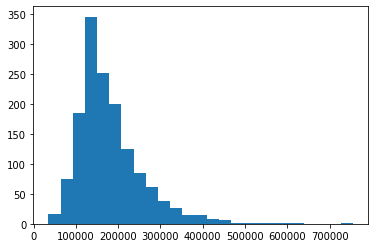

In [175]:
plt.hist(df.saleprice,bins=25)

Looking at the logtransform of saleprice

(array([  4.,   1.,   0.,   5.,   7.,   6.,  26.,  45.,  47., 114., 165.,
        215., 172., 199., 119., 109.,  88.,  52.,  35.,  26.,  12.,   5.,
          4.,   2.,   2.]),
 array([10.46024211, 10.58321134, 10.70618058, 10.82914982, 10.95211906,
        11.07508829, 11.19805753, 11.32102677, 11.443996  , 11.56696524,
        11.68993448, 11.81290371, 11.93587295, 12.05884219, 12.18181142,
        12.30478066, 12.4277499 , 12.55071913, 12.67368837, 12.79665761,
        12.91962684, 13.04259608, 13.16556532, 13.28853455, 13.41150379,
        13.53447303]),
 <BarContainer object of 25 artists>)

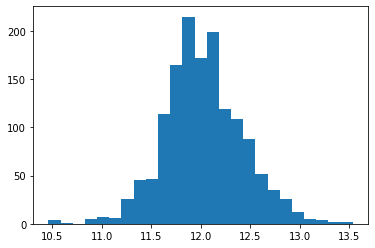

In [177]:
plt.hist(np.log(df.saleprice),bins=25)

Much more normal,  will use IQR to find outliers